 ## WSDM数据分析

 ### 1.导入库

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lightgbm import early_stopping,log_evaluation,LGBMClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob #for sentiment analysis 

 ### 2.数据读取

In [6]:
train = pd.read_parquet("train.parquet")
test = pd.read_parquet("test.parquet")
train.head(4)

,id,prompt,response_a,response_b,winner,model_a,model_b,language
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,Let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian
2,0003800d510e38803efba5ceaec122bc66408fe367b0be...,"Dört basamaklı, rakamları birbirinden ve sıfır...","Bu soruyu çözmek için, verilen koşulları adım ...",Bu problemi adım adım çözelim:\n\n1) ABCD - DC...,model_a,gpt-4-0125-preview,claude-3-5-sonnet-20240620,Turkish
3,00072026c68f5418ef2da238394e418ce72a534b9b22d5...,"현재 추천된 탑 3 종목인 Cabaletta Bio (CABA), Rocket Ph...","죄송하지만 저는 금융 조언을 제공할 수 없습니다. 저는 AI 모델이며, 투자 결정에...",현재 추천된 탑 3 종목에 순위를 매기기 위해서는 여러 가지 요소들을 고려해야 합니...,model_b,gemma-2-2b-it,llama-3.1-nemotron-70b-instruct,English


 ### 3.回答偏好分布

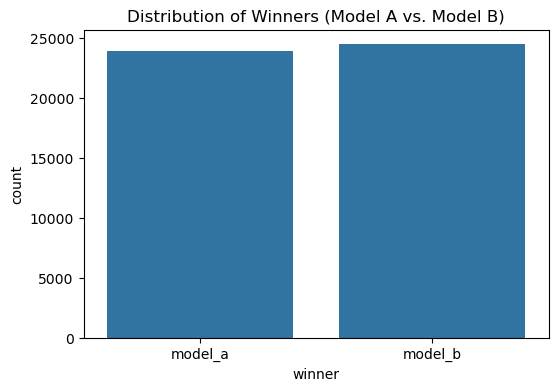

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='winner', data=train)
plt.title('Distribution of Winners (Model A vs. Model B)')
plt.show()

 ### 4.提示词长度分布图

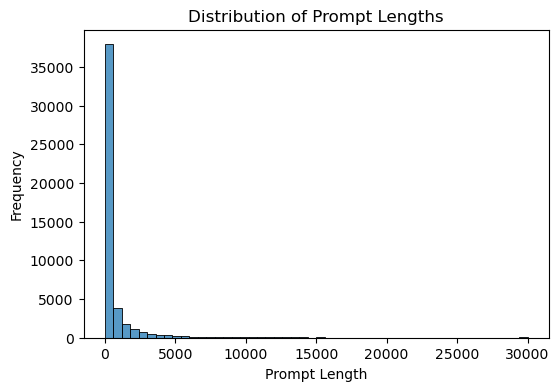

In [8]:
train['prompt_length'] = train['prompt'].apply(len)
plt.figure(figsize=(6, 4))
sns.histplot(train['prompt_length'], bins=50)
plt.title('Distribution of Prompt Lengths')
plt.xlabel('Prompt Length')
plt.ylabel('Frequency')
plt.show()

 ### 5.应答的长度

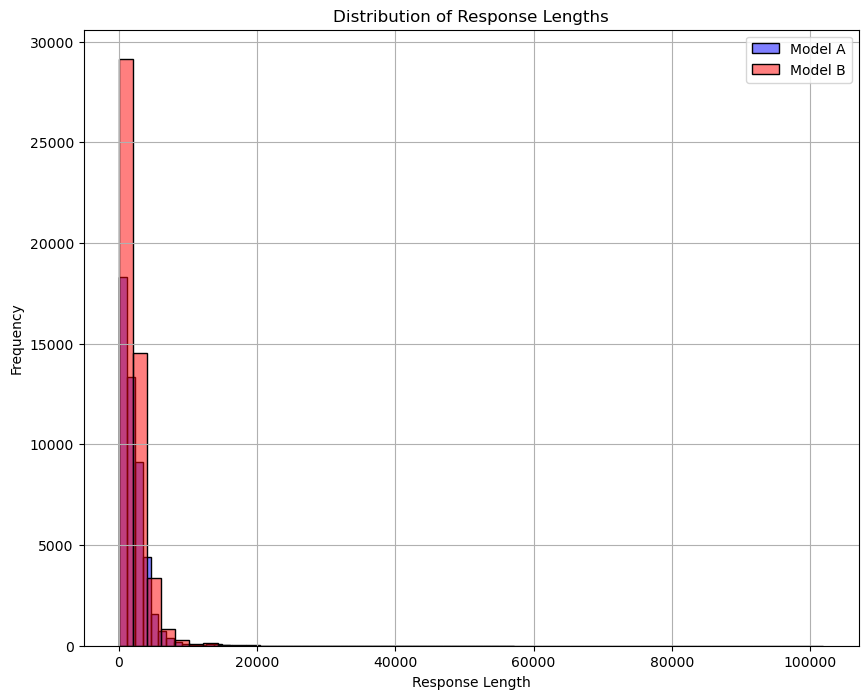

In [9]:
train['response_a_length'] = train['response_a'].apply(len)
train['response_b_length'] = train['response_b'].apply(len)
plt.figure(figsize=(10, 8))
sns.histplot(train['response_a_length'], bins=50, label='Model A', color='blue', alpha=0.5)
sns.histplot(train['response_b_length'], bins=50, label='Model B', color='red', alpha=0.5)
plt.title('Distribution of Response Lengths')
plt.xlabel('Response Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

### 6.数据中的语言分布

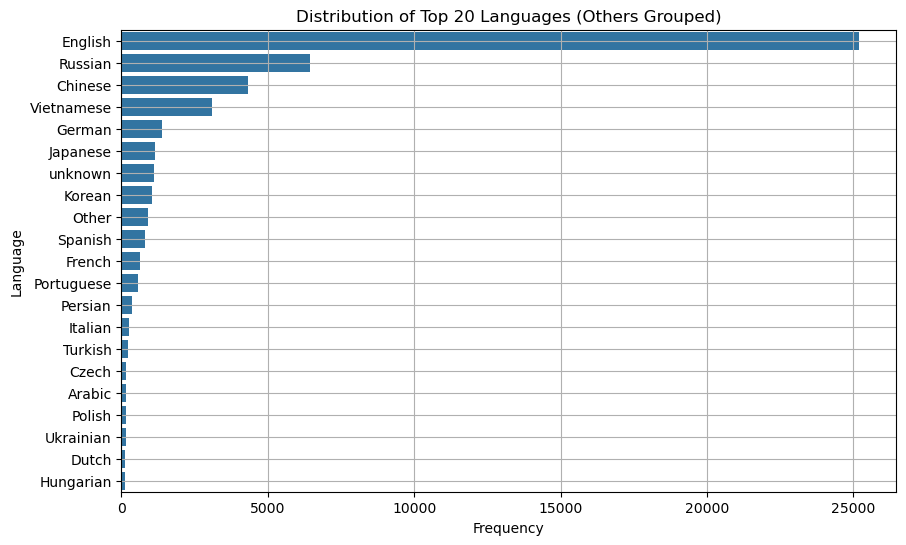

In [10]:
# 统计各语言的数量
language_counts = train['language'].value_counts()
top_languages = language_counts.nlargest(20).index
train['language_grouped'] = train['language'].apply(lambda x: x if x in top_languages else 'Other')
# 重新统计分组后的语言分布
plt.figure(figsize=(10, 6))
sns.countplot(y='language_grouped', data=train, order=train['language_grouped'].value_counts().index)
plt.title('Distribution of Top 20 Languages (Others Grouped)')
plt.xlabel('Frequency')
plt.ylabel('Language')
plt.grid()
plt.show()

### 7.所有应答中的模型选用数量与被选中次数分析

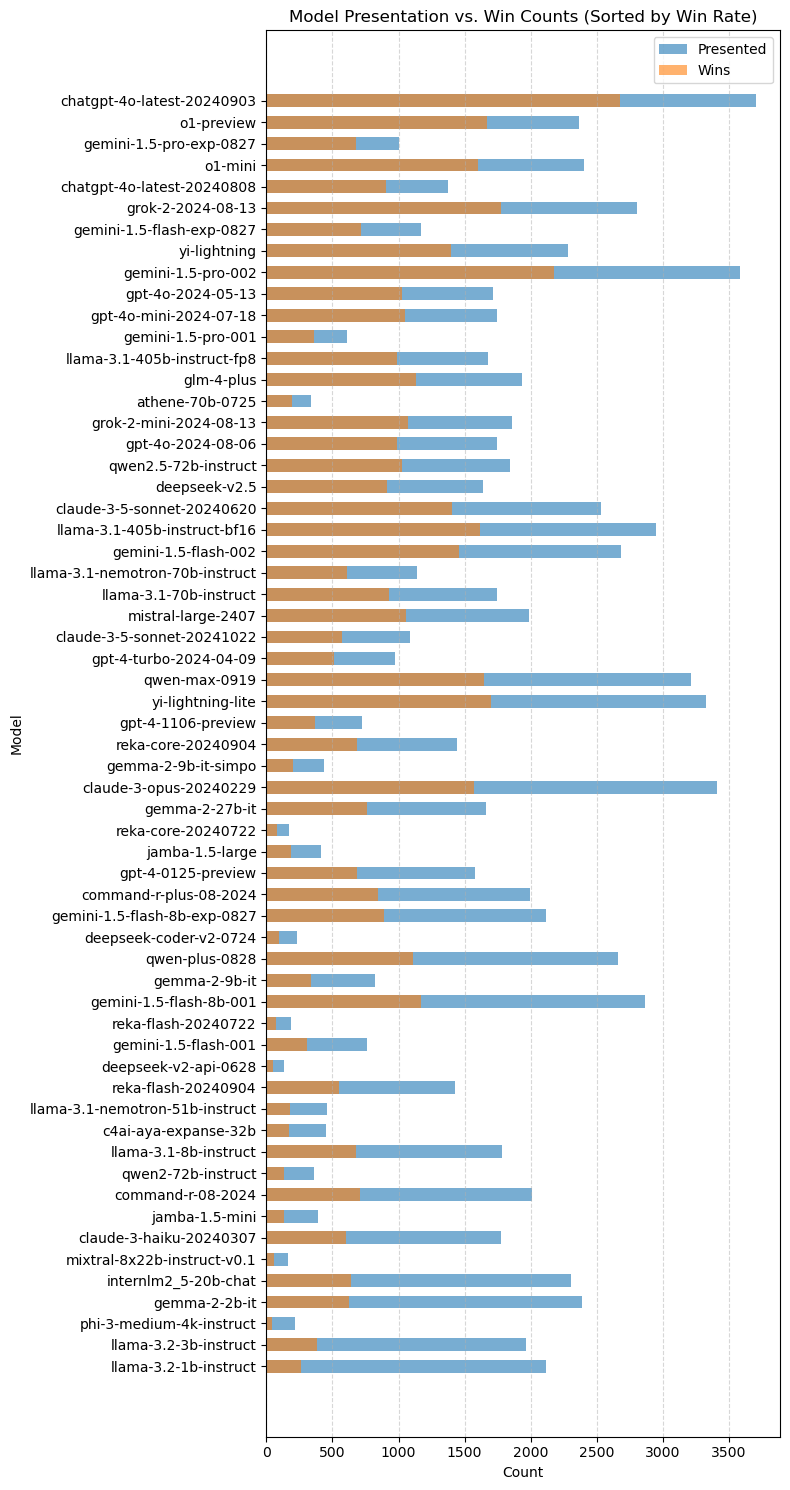

In [11]:
present_counts = pd.concat([train['model_a'], train['model_b']]).value_counts()
train['winner_model'] = train.apply(
    lambda row: row['model_a'] if row['winner']=='model_a' else row['model_b'],
    axis=1
)
win_counts = train['winner_model'].value_counts()

# 对齐、补零
all_models     = present_counts.index.union(win_counts.index)
present_counts = present_counts.reindex(all_models, fill_value=0)
win_counts     = win_counts.reindex(all_models, fill_value=0)

# 计算胜率并按降序排列
win_rate      = win_counts / present_counts
sorted_models = win_rate.sort_values(ascending=False).index

# 重新按胜率顺序排好 present_counts / win_counts
present_counts = present_counts.reindex(sorted_models)
win_counts     = win_counts.reindex(sorted_models)

# 绘图
y      = np.arange(len(sorted_models))
height = 0.6
fig, ax = plt.subplots(figsize=(8, 15))

ax.barh(y, present_counts.values, height=height, label='Presented', alpha=0.6)
ax.barh(y, win_counts.values,     height=height, label='Wins',      alpha=0.6)
ax.set_yticks(y)
ax.set_yticklabels(sorted_models)
ax.set_xlabel('Count')
ax.set_ylabel('Model')
ax.set_title('Model Presentation vs. Win Counts (Sorted by Win Rate)')
ax.legend()
ax.grid(axis='x', linestyle='--', alpha=0.5)

# 把 y 轴反转，这样胜率最高（index 0）会在最上面
ax.invert_yaxis()

plt.tight_layout()
plt.show()


### 8.不同模型的胜率分析

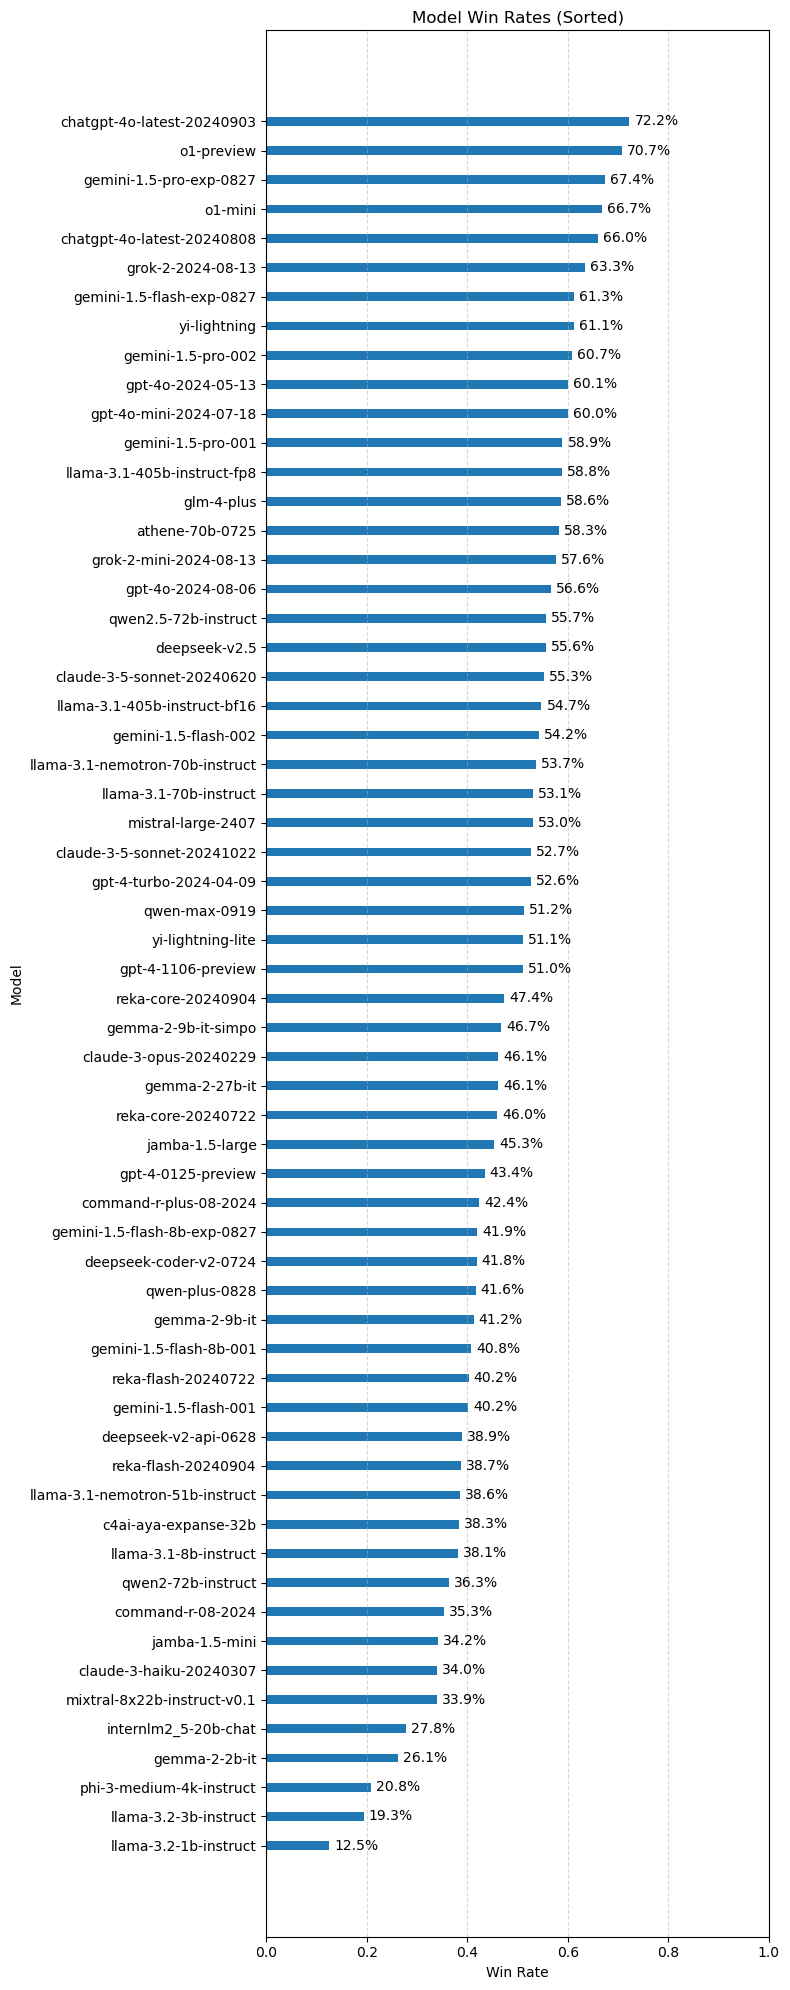

In [12]:
# —— 1. 统计呈现次数 和 胜出次数 —— #
present_counts = pd.concat([train['model_a'], train['model_b']]).value_counts()
train['winner_model'] = train.apply(
    lambda row: row['model_a'] if row['winner']=='model_a' else row['model_b'],
    axis=1
)
win_counts = train['winner_model'].value_counts()

# —— 2. 对齐索引、补零 —— #
all_models     = present_counts.index.union(win_counts.index)
present_counts = present_counts.reindex(all_models, fill_value=0)
win_counts     = win_counts.reindex(all_models,     fill_value=0)

# —— 3. 计算获胜率并排序 —— #
win_rate = (win_counts / present_counts).fillna(0)
win_rate = win_rate.sort_values(ascending=False)  # 降序：最高的在前

# —— 4. 绘图 —— #
fig, ax = plt.subplots(figsize=(8, 20))
y_pos = np.arange(len(win_rate))

ax.barh(y_pos,win_rate.values,height=0.3,alpha=1)

# 翻转 y 轴，让最高获胜率排最上面
ax.invert_yaxis()

# 限定横轴 [0,1]
ax.set_xlim(0, 1)

# 标签
ax.set_yticks(y_pos)
ax.set_yticklabels(win_rate.index)
ax.set_xlabel('Win Rate')
ax.set_ylabel('Model')
ax.set_title('Model Win Rates (Sorted)')

# 在每条上标注百分比
for i, v in enumerate(win_rate.values):
    ax.text(v + 0.01, i, f"{v:.1%}", va='center')

ax.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 9.提示和响应长度关联

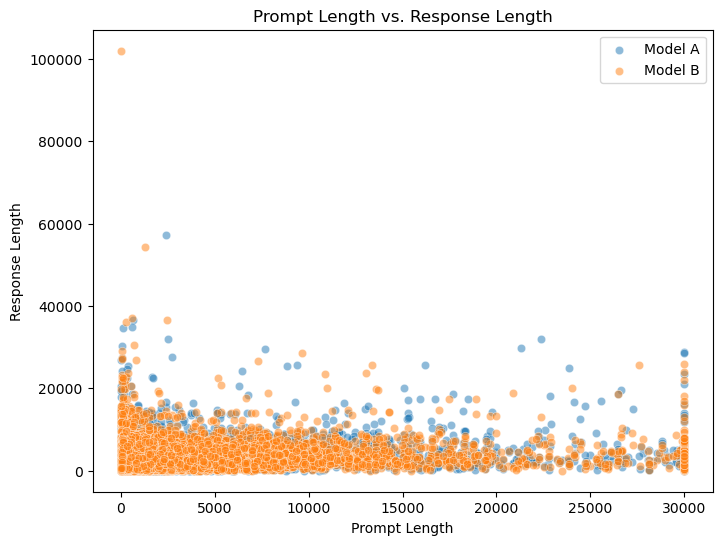

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='prompt_length', y='response_a_length', data=train, label='Model A', alpha=0.5)
sns.scatterplot(x='prompt_length', y='response_b_length', data=train, label='Model B', alpha=0.5)
plt.title('Prompt Length vs. Response Length')
plt.xlabel('Prompt Length')
plt.ylabel('Response Length')
plt.legend()
plt.show()

### 10.选择人类偏好的答案时长度的影响

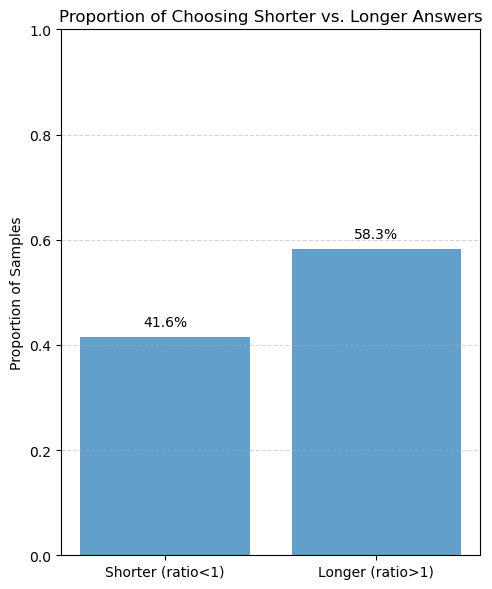

In [14]:
# 1. 计算每个模型的响应长度
train['response_a_length'] = train['response_a'].apply(len)
train['response_b_length'] = train['response_b'].apply(len)

# 2. 根据 winner 列区分“被选中”和“未被选中”的长度
train['chosen_length'] = train.apply(
    lambda row: row['response_a_length'] if row['winner']=='model_a' else row['response_b_length'],
    axis=1
)
train['other_length'] = train.apply(
    lambda row: row['response_b_length'] if row['winner']=='model_a' else row['response_a_length'],
    axis=1
)

# 3. 计算长度比率
train['length_ratio'] = train['chosen_length'] / train['other_length']

# 4. 计算比例
ratios = train['length_ratio'].dropna()

# 5.计算两种情况的样本数
count_shorter = (ratios < 1).sum()
count_longer  = (ratios > 1).sum()

# 6.如果想把恰好等于1的也归入“更长”或“更短”，可以改成 <=1 / >=1
total = len(ratios)

# 7.计算比例
prop_shorter = count_shorter / total
prop_longer  = count_longer  / total

# 8.绘图
plt.figure(figsize=(5, 6))
bars = plt.bar(
    ['Shorter (ratio<1)', 'Longer (ratio>1)'],
    [prop_shorter, prop_longer],
    alpha=0.7
)

# 限制纵轴在 0–1
plt.ylim(0, 1)

# 标注
plt.ylabel('Proportion of Samples')
plt.title('Proportion of Choosing Shorter vs. Longer Answers')
for bar, prop in zip(bars, [prop_shorter, prop_longer]):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        prop + 0.02,
        f"{prop:.1%}",
        ha='center'
    )

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 11.不同语言下获胜选项的偏差分析     

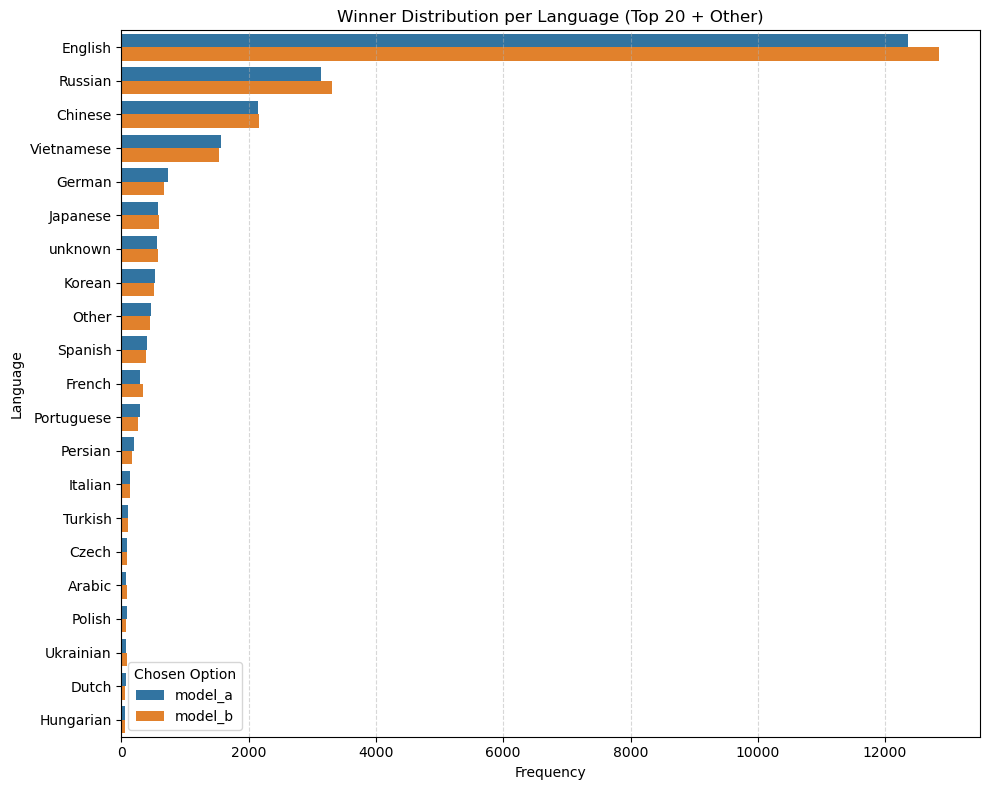

In [15]:
# 1. 统计各语言的数量并取前20
language_counts = train['language'].value_counts()
top20 = language_counts.nlargest(20).index

# 2. 新增一列，把不在前20的语言标为 'Other'
train['language_grouped'] = train['language'].apply(lambda x: x if x in top20 else 'Other')

# 3. 确定绘图顺序：按分组后语言整体频次排序
order = train['language_grouped'].value_counts().index

# 4. 绘图
plt.figure(figsize=(10, 8))
sns.countplot(
    y='language_grouped',
    hue='winner',
    data=train,
    order=order
)
plt.title('Winner Distribution per Language (Top 20 + Other)')
plt.xlabel('Frequency')
plt.ylabel('Language')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend(title='Chosen Option')
plt.tight_layout()
plt.show()


### 11.不同模型下的选项偏差

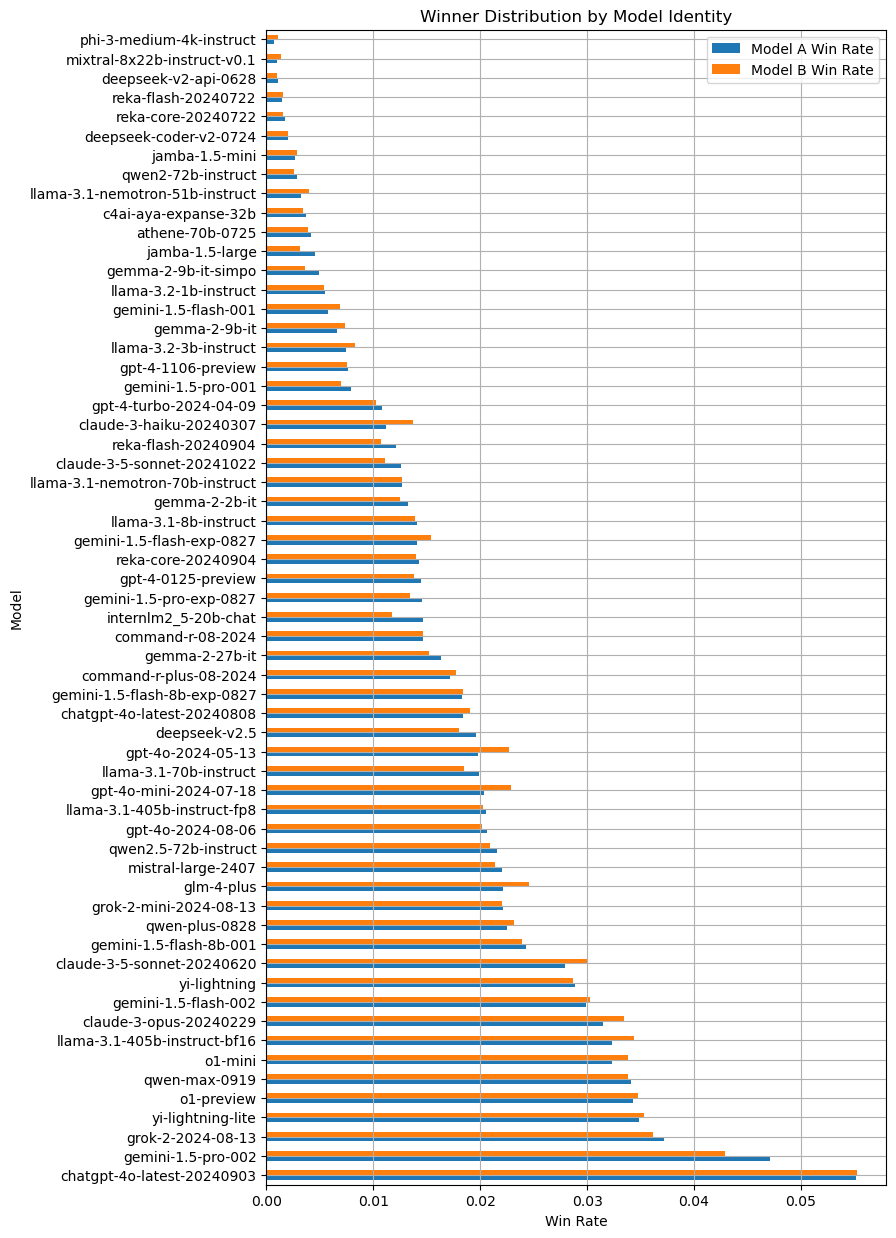

In [16]:
model_a_win_rate = train[train['winner'] == 'model_a']['model_a'].value_counts(normalize=True)
model_b_win_rate = train[train['winner'] == 'model_b']['model_b'].value_counts(normalize=True)
win_rates = pd.concat([model_a_win_rate, model_b_win_rate], axis=1)
win_rates.columns = ['Model A Win Rate', 'Model B Win Rate']
win_rates.plot(kind='barh', figsize=(8, 15))
plt.title('Winner Distribution by Model Identity')
plt.ylabel('Model')
plt.xlabel('Win Rate')
plt.grid()
plt.show()